In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, RegexpTokenizer, TweetTokenizer 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from nltk import FreqDist

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB

from imblearn.pipeline import Pipeline
 
from wordcloud import WordCloud
from PIL import Image 
import string
import re


import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nathanwalter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [93]:
df = pd.read_csv('phase-4-dataset.csv', encoding= 'latin1')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


# Data Cleaning

Dropping an unnecessary label

In [94]:
#df = df.drop(6, axis=0)
df = df.dropna(axis=0, subset=['tweet_text'])

Renaming Columns

In [95]:
df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product" : "emotion"}, inplace=True)

Adding a label encoder to our target column

In [96]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['emotion'])
df['label'] = le.transform(df['emotion'])
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3


In [97]:
df.label.unique()

array([1, 3, 2, 0])

Looking at the "I can't tell" tweets

In [98]:
df.loc[df['label'] == 0]

,tweet_text,emotion_in_tweet_is_directed_at,emotion,label
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell,0
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell,0
237,Just what America needs. RT @mention Google to...,NaN,I can't tell,0
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell,0
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell,0
...,...,...,...,...
9020,It's funny watching a room full of people hold...,NaN,I can't tell,0
9032,"@mention yeah, we have @mention , Google has n...",NaN,I can't tell,0
9037,"@mention Yes, the Google presentation was not ...",NaN,I can't tell,0
9058,&quot;Do you know what Apple is really good at...,NaN,I can't tell,0


In [99]:
df['emotion'].value_counts(normalize=True)

No emotion toward brand or product    0.592609
Positive emotion                      0.327541
Negative emotion                      0.062692
I can't tell                          0.017158
Name: emotion, dtype: float64

## Dropping the "I Can't Tell" rows

In [232]:
df.drop(df[df['label']==0].index, inplace = True)
df.label.value_counts()

2    5388
3    2978
1     570
Name: label, dtype: int64

## Dropping any NANs

In [101]:
df['tweet_text'].dropna(inplace=True)

In [102]:
len(df)

8936

## Functions that strip mentions, retweets, and embedded things

In [103]:
#Create a function to clean the Tweets
def remove_junk(text):
    text = re.sub(r'@[A-Za-z0-9#]+', '', str(text)) #remove @mentions 
    text = re.sub(r'RT[\s]+', '', str(text)) # remove RT
    text = re.sub(r'\[VIDEO\]', '', str(text)) # remove [VIDEO] describer
    text = re.sub(r'\{link\}', '', str(text)) # remove {link} describer
    text = re.sub(r'https?:\/\/\S+', '', text) # removes actual links
    text = re.sub(r'#', '', str(text)) # remove hashtag symbol
    text = re.sub(r'&quot', '', str(text)) # remove weird quote symbol
    text = re.sub(r'&amp', '', str(text)) # remove weird and symbol
    
    text = re.sub(r'SXSW', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'Android', '', str(text)) # remove hashtag symbol
    text = re.sub(r'iPhone', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'Google', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'apple', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'store', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'app ', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'ipad', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'austin', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    #text = re.sub(r'[^A-Za-z0-9#]', '', str(text)) # remove weird and symbol
    #text = re.sub(r'[\,\.\?\*\$\'\"\!\(\)\:\_\/\-\=\^\;]+', '', text)
    return text



In [104]:
#Create a function that tokenizes text
def tokenize(text):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokenized_tweet = regex_token.tokenize(text)
    tweet_tokens = [word.lower() for word in tokenized_tweet]
    #cleaned_tweet = [word for word in lowered_tokens if word not in sw]
    return tweet_tokens

In [105]:
#Create a function that removes stopwords and punctuation 
punctuations = string.punctuation

def remove_sw_punct(tweet_tokens):
    tweets_clean = []
    
    for word in tweet_tokens:
        if (word not in stopwords and word not in punctuations):
            tweets_clean.append(word)
            
    return tweets_clean

In [106]:
stemmer = PorterStemmer()

def stemming(tweets_clean):
    tweets_stem = [stemmer.stem(token) for token in tweets_clean]         
    return tweets_stem

In [107]:
#Combining the preprocessing into a function
def process_tweet(text):
    processed_tweet = remove_junk(text)
    tweet_tokens = tokenize(processed_tweet)
    tweets_clean = remove_sw_punct(tweet_tokens)
    tweets_stem = stemming(tweets_clean)
    return tweets_clean

In [108]:
#pop 'can't' from stopwords
tweet_example = df['tweet_text'][0]
print(tweet_example)

processed_tweet = process_tweet(tweet_example)
print(processed_tweet)

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
['g', 'hrs', 'tweeting', 'rise', 'dead', 'need', 'upgrade', 'plugin', 'stations']


In [109]:
df['processedtwitter'] = [process_tweet(i) for i in df['tweet_text']]
df['processedtwitter']

0       [g, hrs, tweeting, rise, dead, need, upgrade, ...
1       [know, awesome, likely, appreciate, design, al...
2                                      [wait, also, sale]
3               [hope, year, festival, crashy, year, app]
4       [great, stuff, fri, marissa, mayer, tim, reill...
                              ...                        
9088                                         [everywhere]
9089    [wave, buzz, interrupt, regularly, scheduled, ...
9090    [zeiger, physician, never, reported, potential...
9091    [verizon, customers, complained, time, fell, b...
9092                               [tests, check, offers]
Name: processedtwitter, Length: 8936, dtype: object

In [110]:
nltk.pos_tag(processed_tweet)

[('g', 'NN'),
 ('hrs', 'NN'),
 ('tweeting', 'VBG'),
 ('rise', 'NN'),
 ('dead', 'JJ'),
 ('need', 'NN'),
 ('upgrade', 'JJ'),
 ('plugin', 'NN'),
 ('stations', 'NNS')]

In [111]:
df.loc[11]

tweet_text                         Find &amp; Start Impromptu Parties at #SXSW Wi...
emotion_in_tweet_is_directed_at                                          Android App
emotion                                                             Positive emotion
label                                                                              3
processedtwitter                   [find, start, impromptu, parties, wait, til, c...
Name: 11, dtype: object

## Prep for Wordcloud 

In [112]:
data_neg = df['processedtwitter'].loc[df['label'] == 1]

negative_sentiment = []
for i in data_neg:
    listToStr = ' '.join(map(str, i))
    negative_sentiment.append(listToStr)
negative_sentiment = ' '.join(map(str,  negative_sentiment))


In [113]:
data_pos = df['processedtwitter'].loc[df['label'] == 3]

positive_sentiment = []
for i in data_pos:
    listToStr = ' '.join(map(str, i))
    positive_sentiment.append(listToStr)
positive_sentiment = ' '.join(map(str,  positive_sentiment))

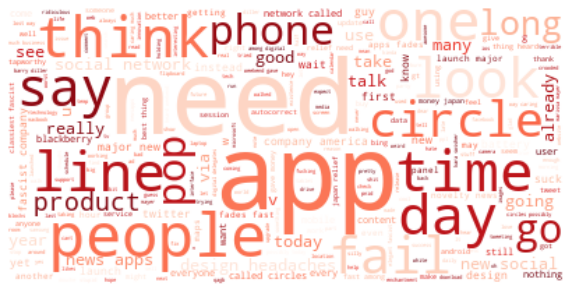

In [114]:
# instantiate a word cloud object
wc = WordCloud(
    background_color='white',
    max_words=2000,
    colormap='Reds'
)
# generate the word cloud
wc.generate(negative_sentiment)

plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

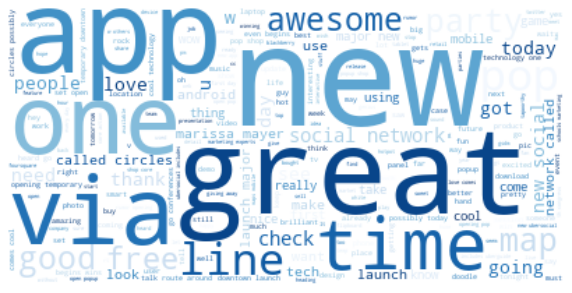

In [115]:


wc = WordCloud(
    background_color='white',
    max_words=2000,
    colormap='Blues'
)

wc.generate(positive_sentiment)

plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Train Test Split

In [116]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = .90)

In [117]:
example_freq_dist = FreqDist(X_train.iloc[100]["processedtwitter"][:20])
example_freq_dist

FreqDist({'going': 1, 'check': 1, 'pop': 1, 'shop': 1, 'let': 1, 'us': 1, 'know': 1})

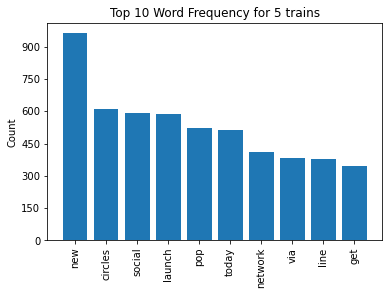

In [118]:
import matplotlib.pyplot as plt


def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
train_freq_dist = FreqDist(X_train['processedtwitter'].explode())

# Plot the top 10 tokens
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for 5 trains")

In [119]:
X_train['emotion'].value_counts(normalize=True)

No emotion toward brand or product    0.602959
Positive emotion                      0.333250
Negative emotion                      0.063790
Name: emotion, dtype: float64

In [120]:
# Instantiate a vectorizer with max_features=20
tfidf = TfidfVectorizer(
    max_features=20,
    stop_words=stopwords,
    tokenizer=tokenize
)

# Fit the vectorizer on X_train["tweet_text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet_text'])


# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,amp,android,app,apple,austin,circles,google,ipad,iphone,launch,link,mention,new,pop,quot,rt,social,store,sxsw,today
0,0.0,0.0,0.000000,0.178577,0.238998,0.0,0.000000,0.000000,0.000000,0.0,0.128824,0.235483,0.000000,0.828218,0.0,0.324067,0.0,0.206478,0.073109,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.687826,0.0,0.000000,0.400833,0.000000,0.000000,0.0,0.551619,0.0,0.000000,0.248888,0.0
2,0.0,0.0,0.000000,0.000000,0.792424,0.0,0.559739,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.242399,0.0
3,0.0,0.0,0.709301,0.000000,0.000000,0.0,0.000000,0.000000,0.568495,0.0,0.362477,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.205708,0.0
4,0.0,0.0,0.000000,0.696277,0.465931,0.0,0.000000,0.000000,0.000000,0.0,0.251145,0.229539,0.000000,0.000000,0.0,0.000000,0.0,0.402531,0.142526,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8037,0.0,0.0,0.000000,0.713422,0.000000,0.0,0.000000,0.636964,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.292072,0.0
8038,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.620749,0.000000,0.000000,0.0,0.000000,0.432935,0.000000,0.000000,0.0,0.595796,0.0,0.000000,0.268820,0.0
8039,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.661070,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.750324,0.0
8040,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.719764,0.0,0.458927,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.520889,0.0


In [121]:
tfidf = TfidfVectorizer(max_features=25)
X_train_vectorized = tfidf.fit_transform(X_train['tweet_text'])
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,and,apple,at,austin,for,google,in,ipad,iphone,is,...,on,quot,rt,store,sxsw,the,to,up,with,you
0,0.000000,0.266932,0.000000,0.357357,0.000000,0.000000,0.285887,0.0,0.000000,0.0,...,0.328029,0.0,0.484472,0.308672,0.109247,0.000000,0.000000,0.330065,0.0,0.000000
1,0.495161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.491894,0.0,...,0.000000,0.0,0.394400,0.000000,0.177872,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.640938,0.000000,0.452401,0.000000,0.0,0.000000,0.0,...,0.588336,0.0,0.000000,0.000000,0.195940,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.375619,0.000000,0.415557,0.000000,0.000000,0.0,0.480437,0.0,...,0.000000,0.0,0.000000,0.000000,0.173729,0.000000,0.000000,0.000000,0.0,0.575788
4,0.000000,0.561357,0.000000,0.375761,0.000000,0.000000,0.300610,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.324568,0.114873,0.000000,0.000000,0.347063,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8037,0.000000,0.312001,0.000000,0.000000,0.305438,0.000000,0.000000,0.0,0.000000,0.0,...,0.383413,0.0,0.000000,0.000000,0.127692,0.247480,0.536021,0.000000,0.0,0.000000
8038,0.000000,0.000000,0.000000,0.000000,0.297967,0.287614,0.000000,0.0,0.000000,0.0,...,0.374034,0.0,0.276209,0.000000,0.124569,0.000000,0.522910,0.000000,0.0,0.000000
8039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.492326,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.376269,0.364622,0.000000,0.000000,0.0,0.000000
8040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.627018,0.0,...,0.000000,0.0,0.000000,0.000000,0.226734,0.000000,0.000000,0.000000,0.0,0.000000


In [122]:
y_train.value_counts(normalize=True)

2    0.602959
3    0.333250
1    0.063790
Name: label, dtype: float64

In [123]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [124]:
def doc_preparer(doc):
 
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [126]:
train_docs = [doc_preparer(doc) for doc in X_train['processedtwitter']]
test_docs = [doc_preparer(doc) for doc in X_test['processedtwitter']]
train_docs[2:7]

['drive around street view scoping location desk',
 'foodspotting success find food crave',
 'temp set downtown via even begin win dtph com',
 'web designer guide io apps today',
 'attend guide free download itunes lp']

## Baseline Model

In [188]:
dum_pipe = Pipeline([('count', CountVectorizer()),
                    ('model', DummyClassifier())])

model = dum_pipe.fit(train_docs, y_train)

y_trn_pred = dum_pipe.predict(train_docs)
y_tst_pred = dum_pipe.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

		The Train Results
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       513
           2       0.60      1.00      0.75      4849
           3       0.00      0.00      0.00      2680

    accuracy                           0.60      8042
   macro avg       0.20      0.33      0.25      8042
weighted avg       0.36      0.60      0.45      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        57
           2       0.60      1.00      0.75       539
           3       0.00      0.00      0.00       298

    accuracy                           0.60       894
   macro avg       0.20      0.33      0.25       894
weighted avg       0.36      0.60      0.45       894



In [191]:
nb_pipe1 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', MultinomialNB())])

model = nb_pipe1.fit(train_docs, y_train)

pred  = model.predict(test_docs)

print(classification_report(y_test,
                            pred
                            ))

              precision    recall  f1-score   support

           1       1.00      0.02      0.03        57
           2       0.66      0.93      0.77       539
           3       0.66      0.29      0.40       298

    accuracy                           0.66       894
   macro avg       0.77      0.41      0.40       894
weighted avg       0.68      0.66      0.60       894



In [192]:
from imblearn.pipeline       import Pipeline 
from sklearn.model_selection import cross_validate
from imblearn.over_sampling  import RandomOverSampler
import numpy as np
from sklearn.metrics import precision_score

nb_pipe2  = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('model',   MultinomialNB())])

nb_pipe2.fit(train_docs, y_train)
nb_pipe2.score(test_docs, y_test)

0.6040268456375839

In [193]:
y_trn_pred = nb_pipe2.predict(train_docs)
y_tst_pred = nb_pipe2.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))
    

		The Train Results
              precision    recall  f1-score   support

           1       0.36      0.96      0.52       513
           2       0.78      0.88      0.83      4849
           3       0.93      0.41      0.57      2680

    accuracy                           0.73      8042
   macro avg       0.69      0.75      0.64      8042
weighted avg       0.80      0.73      0.72      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.23      0.67      0.34        57
           2       0.68      0.80      0.74       539
           3       0.73      0.23      0.36       298

    accuracy                           0.60       894
   macro avg       0.55      0.57      0.48       894
weighted avg       0.67      0.60      0.58       894



In [194]:
from imblearn.over_sampling import SMOTE
nb_pipe2  = Pipeline([('vect',    CountVectorizer(ngram_range=(1, 3))),
                     ('tfidf',   TfidfTransformer()),
                     ('smt', SMOTE(random_state=42)),
                     ('model',   MultinomialNB())])

nb_pipe2.fit(train_docs, y_train)
nb_pipe2.score(test_docs, y_test)

0.6364653243847874

In [195]:
y_trn_pred = nb_pipe2.predict(train_docs)
y_tst_pred = nb_pipe2.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

		The Train Results
              precision    recall  f1-score   support

           1       0.72      0.99      0.84       513
           2       0.96      0.89      0.92      4849
           3       0.86      0.92      0.89      2680

    accuracy                           0.90      8042
   macro avg       0.85      0.93      0.88      8042
weighted avg       0.91      0.90      0.91      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.32      0.67      0.43        57
           2       0.77      0.65      0.71       539
           3       0.56      0.61      0.59       298

    accuracy                           0.64       894
   macro avg       0.55      0.64      0.57       894
weighted avg       0.67      0.64      0.65       894



In [196]:

nb_pipe3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', MultinomialNB(
        fit_prior=True, class_prior=None)),
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4)],
    #'clf__estimator__alpha': (1e-2, 1e-3, 1e-4)
}

grid_search_pipe3 = GridSearchCV(nb_pipe3, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_pipe3.fit(train_docs, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
 

In [197]:
pipe_3_best = grid_search_pipe3.best_estimator_

In [198]:
y_trn_pred = pipe_3_best.predict(train_docs)
y_tst_pred = pipe_3_best.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

		The Train Results
              precision    recall  f1-score   support

           1       0.93      0.05      0.10       513
           2       0.77      0.99      0.87      4849
           3       0.96      0.64      0.77      2680

    accuracy                           0.81      8042
   macro avg       0.89      0.56      0.58      8042
weighted avg       0.84      0.81      0.79      8042


		The Test Results
              precision    recall  f1-score   support

           1       1.00      0.04      0.07        57
           2       0.65      0.96      0.77       539
           3       0.73      0.23      0.35       298

    accuracy                           0.66       894
   macro avg       0.79      0.41      0.40       894
weighted avg       0.70      0.66      0.59       894



## Pipeline Random Forest

In [199]:
rf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('sampler', RandomOverSampler('minority',random_state=42)),
    ('clf', RandomForestClassifier())
    
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4)],
    'clf__max_depth': [5,10,20],
    'clf__max_features': [3,11,15],
    'clf__min_samples_leaf': [2,8,10],
    'clf__min_samples_split': [3,7,10],
    'clf__n_estimators': [10,75],
    
}


rf_grid_search = GridSearchCV(rf_pipe, parameters, cv=2, n_jobs=-1, verbose=3)

# Uncomment for Random Forest Pipeline Grid Search results. But, make sure you 
# have some free time, it takes several minutes.

#grid_search_pipe4.fit(train_docs, y_train)

In [200]:
#rf_grid_best = grid_search_pipe4.best_estimator_

In [201]:
# y_trn_pred = rf_grid_best.predict(train_docs)
# y_tst_pred = rf_grid_best.predict(test_docs)
    
# print('\t\tThe Train Results')
# print(classification_report(y_train, y_trn_pred))
# print('\n\t\tThe Test Results')
# print(classification_report(y_test, y_tst_pred))

Function to check if the accuracy score changes with max_features increased

In [202]:
def max_features_check(n):

#     train_docs = [doc_preparer(doc) for doc in X_train['processedtwitter']]
#     test_docs = [doc_preparer(doc) for doc in X_test['processedtwitter']]

    # Secondary train-test split to build our best model
    X_t, X_val, y_t, y_val = train_test_split(train_docs, y_train,
                                              test_size=0.25, random_state=42)
    # here's where our 'n' comes in
    cv = CountVectorizer(max_features=n)

    X_t_vec = cv.fit_transform(X_t)
    X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
    X_t_vec.columns = sorted(cv.vocabulary_)
    X_t_vec.set_index(y_t.index, inplace=True)

    # We then transform the validation set. (Do not refit the vectorizer!)

    X_val_vec = cv.transform(X_val)
    X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
    X_val_vec.columns = sorted(cv.vocabulary_)
    X_val_vec.set_index(y_val.index, inplace=True)

    mnb = MultinomialNB()

    mnb.fit(X_t_vec, y_t)
    y_hat = mnb.predict(X_val_vec)
    
    
    return accuracy_score(y_val, y_hat)



In [203]:
print(max_features_check(2))
print(max_features_check(3))
print(max_features_check(4))
print(max_features_check(8))
print(max_features_check(9))
print(max_features_check(10))
print(max_features_check(11))
print(max_features_check(12))
print(max_features_check(20))
print(max_features_check(30))
print(max_features_check(40))
print(max_features_check(50))

0.5972153157633019
0.5972153157633019
0.5987071108901044
0.5902536051715565
0.5897563401292889
0.5882645450024864
0.5872700149179513
0.590750870213824
0.5887618100447538
0.5892590750870214
0.5922426653406265
0.6006961710591745


Checking if Pipe_3 does better with some changes to params

In [204]:

nb_pipe3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', MultinomialNB()) # removed fit_prior=True, class_prior=None
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4)],
    #'clf__estimator__alpha': (1e-2, 1e-3, 1e-4)
}

grid_search_pipe3 = GridSearchCV(nb_pipe3, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_pipe3.fit(train_docs, y_train)

pipe_3_best = grid_search_pipe3.best_estimator_

y_trn_pred = pipe_3_best.predict(train_docs)
y_tst_pred = pipe_3_best.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
		The Train Results
              precision    recall  f1-score   support

           1       0.93      0.05      0.10       513
           2       0.77      0.99      0.87      4849
           3       0.96      0.64      0.77      2680

    accuracy                           0.81      8042
   macro avg       0.89      0.56      0.58      8042
weighted avg       0.84      0.81      0.79      8042


		The Test Results
              precision    recall  f1-score   support

           1       1.00      0.04      0.07        57
           2       0.65      0.96      0.77       539
           3       0.73      0.23      0.35       298

    accuracy                           0.66       894
   macro avg       0.79      0.41      0.40       894
weighted avg       0.70      0.66      0.59       894



changing n_jobs from 2 to -1

In [205]:
nb_pipe3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', MultinomialNB()) # removed fit_prior=True, class_prior=None
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4)],
    #'clf__estimator__alpha': (1e-2, 1e-3, 1e-4)
}

grid_search_pipe3 = GridSearchCV(nb_pipe3, parameters, cv=5, n_jobs=-1, verbose=2)
grid_search_pipe3.fit(train_docs, y_train)

pipe_3_best = grid_search_pipe3.best_estimator_

y_trn_pred = pipe_3_best.predict(train_docs)
y_tst_pred = pipe_3_best.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

[CV 2/2] END tfidf__max_df=0.25, tfidf__ngram_range=(1, 2);, score=0.646 total time=   0.2s
[CV 2/2] END tfidf__max_df=0.25, tfidf__ngram_range=(1, 3);, score=0.646 total time=   0.2s
[CV 2/2] END tfidf__max_df=0.25, tfidf__ngram_range=(1, 4);, score=0.644 total time=   0.3s
[CV 2/2] END tfidf__max_df=0.5, tfidf__ngram_range=(1, 2);, score=0.646 total time=   0.1s
[CV 2/2] END tfidf__max_df=0.5, tfidf__ngram_range=(1, 3);, score=0.646 total time=   0.2s
[CV 2/2] END tfidf__max_df=0.5, tfidf__ngram_range=(1, 4);, score=0.644 total time=   0.2s
[CV 2/2] END tfidf__max_df=0.75, tfidf__ngram_range=(1, 2);, score=0.646 total time=   0.1s
[CV 2/2] END tfidf__max_df=0.75, tfidf__ngram_range=(1, 3);, score=0.646 total time=   0.2s
[CV 2/2] END tfidf__max_df=0.75, tfidf__ngram_range=(1, 4);, score=0.644 total time=   0.3s
[CV 2/2] END tfidf__max_df=0.25, tfidf__ngram_range=(1, 2);, score=0.646 total time=   0.2s
[CV 2/2] END tfidf__max_df=0.25, tfidf__ngram_range=(1, 3);, score=0.646 total time

checking if max jobs does the trick

In [206]:
nb_pipe3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', MultinomialNB()) # removed fit_prior=True, class_prior=None
])
parameters = {
    'tfidf__max_df': (0.15, 0.20, 0.25),
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4)],
    #'clf__estimator__alpha': (1e-2, 1e-3, 1e-4)
}

grid_search_pipe3 = GridSearchCV(nb_pipe3, parameters, cv=2, n_jobs=-1, verbose=3)
grid_search_pipe3.fit(train_docs, y_train)

pipe_3_best = grid_search_pipe3.best_estimator_

y_trn_pred = pipe_3_best.predict(train_docs)
y_tst_pred = pipe_3_best.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
		The Train Results
              precision    recall  f1-score   support

           1       0.93      0.05      0.10       513
           2       0.77      0.99      0.87      4849
           3       0.96      0.64      0.77      2680

    accuracy                           0.81      8042
   macro avg       0.89      0.56      0.58      8042
weighted avg       0.84      0.81      0.79      8042


		The Test Results
              precision    recall  f1-score   support

           1       1.00      0.04      0.07        57
           2       0.65      0.96      0.77       539
           3       0.73      0.23      0.35       298

    accuracy                           0.66       894
   macro avg       0.79      0.41      0.40       894
weighted avg       0.70      0.66      0.59       894



## MNnbayes / TFIDF gridsearch

### Uncomment to run grid search

In [217]:
# import time
# start = time.time()

# tf_nb_pipe = Pipeline([
#     ('tfidf', TfidfVectorizer(stop_words=stopwords, tokenizer=tokenize)),
#     ('smt', SMOTE(random_state=42)),
#     ('mnb', MultinomialNB()),
# ])
# parameters = {
#     'tfidf__max_df': (0.25, 0.5, 0.75, 0.80, 0.90),
#     'tfidf__min_df': (2, 3),
#     'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'tfidf__max_features': (3000, 5000, 7000),
#     'tfidf__norm': ('l1', 'l2'),
#     'smt__k_neighbors': (2,5,7),
#     'mnb__alpha': (0.5, 1.0, 2.0)
    
# }


# grid_search = GridSearchCV(tf_nb_pipe, parameters, cv=2, n_jobs=-1, verbose=3)
# grid_search.fit(train_docs, y_train)   # ********Uncomment this line to run grid search*******

# tf_nb_best_pipe = grid_search.best_estimator_

# y_trn_pred = tf_nb_best_pipe.predict(train_docs)
# y_tst_pred = tf_nb_best_pipe.predict(test_docs)
    
# print('\t\tThe Train Results')
# print(classification_report(y_train, y_trn_pred))     # ****Uncomment This cell to run****
# print('\n\t\tThe Test Results')
# print(classification_report(y_test, y_tst_pred))

# end = time.time()
# print(end - start, "seconds")

In [218]:
# tf_nb_best_pipe = grid_search.best_params_ 
# tf_nb_best  # *****uncomment after running above cell*****

## Model with Best Parameters from Grid Search Applied

In [225]:
tf_nb_best_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, tokenizer=tokenize, 
                              max_df=0.25, max_features=7000,
                             min_df=2, ngram_range=(1,2))),
    ('smt', SMOTE(random_state=42,k_neighbors=2)),
    ('mnb', MultinomialNB(alpha=0.5))])

tf_nb_best_pipe.fit(train_docs, y_train)

y_trn_pred = tf_nb_best_pipe.predict(train_docs)
y_tst_pred = tf_nb_best_pipe.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))     # ****Uncomment This cell to run****
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

		The Train Results
              precision    recall  f1-score   support

           1       0.45      0.92      0.60       513
           2       0.89      0.73      0.80      4849
           3       0.70      0.79      0.75      2680

    accuracy                           0.76      8042
   macro avg       0.68      0.82      0.72      8042
weighted avg       0.80      0.76      0.77      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.24      0.49      0.32        57
           2       0.76      0.60      0.67       539
           3       0.53      0.63      0.57       298

    accuracy                           0.60       894
   macro avg       0.51      0.57      0.52       894
weighted avg       0.65      0.60      0.62       894



## Final Model with Execution Time

In [226]:
import time
start = time.time()


tf_nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, 
                              tokenizer=tokenize, 
                              max_df=0.25, max_features=85000,
                             ngram_range=(1,3))),
    ('smt', SMOTE(random_state=42)),
    ('mnb', MultinomialNB(alpha=0.005)),
])

tf_nb_pipe.fit(train_docs, y_train)


y_trn_pred = tf_nb_pipe.predict(train_docs)
y_tst_pred = tf_nb_pipe.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

end = time.time()
print(end - start, "seconds")

		The Train Results
              precision    recall  f1-score   support

           1       0.82      1.00      0.90       513
           2       0.98      0.92      0.95      4849
           3       0.89      0.96      0.92      2680

    accuracy                           0.94      8042
   macro avg       0.90      0.96      0.92      8042
weighted avg       0.94      0.94      0.94      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.49      0.53      0.51        57
           2       0.74      0.72      0.73       539
           3       0.56      0.58      0.57       298

    accuracy                           0.66       894
   macro avg       0.60      0.61      0.60       894
weighted avg       0.66      0.66      0.66       894

0.7851390838623047 seconds


## Function to check for Max Features

In [227]:
def max_features_check(f):

    import time
    start = time.time()


    tf_nb_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, 
                                  tokenizer=tokenize, 
                                  max_df=0.25, max_features=f,
                                 ngram_range=(1,3))),
        ('smt', SMOTE(random_state=42)),
        ('mnb', MultinomialNB(alpha=0.5)),
    ])

    tf_nb_pipe.fit(train_docs, y_train)

    y_trn_pred = tf_nb_pipe.predict(train_docs)
    y_tst_pred = tf_nb_pipe.predict(test_docs)

    print('\t\tThe Train Results')
    print(classification_report(y_train, y_trn_pred))
    print('\n\t\tThe Test Results')
    print(classification_report(y_test, y_tst_pred))

    end = time.time()
    print(end - start, "seconds")

In [222]:
print(max_features_check(4400))
print(max_features_check(8400))
print(max_features_check(44000))
print(max_features_check(85000))
print(max_features_check(125000))

		The Train Results
              precision    recall  f1-score   support

           1       0.36      0.93      0.52       513
           2       0.88      0.66      0.75      4849
           3       0.65      0.75      0.70      2680

    accuracy                           0.70      8042
   macro avg       0.63      0.78      0.65      8042
weighted avg       0.77      0.70      0.72      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.23      0.58      0.33        57
           2       0.76      0.53      0.63       539
           3       0.51      0.64      0.57       298

    accuracy                           0.57       894
   macro avg       0.50      0.58      0.51       894
weighted avg       0.65      0.57      0.59       894

0.7096948623657227 seconds
None
		The Train Results
              precision    recall  f1-score   support

           1       0.42      0.95      0.58       513
           2       0.90      0.70    

## Function to check for Alpha

In [228]:
def checking_for_alpha(a):
    import time
    start = time.time()


    tf_nb_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, 
                                  tokenizer=tokenize, 
                                  max_df=0.25, max_features=85000,
                                 ngram_range=(1,3))),
        ('smt', SMOTE(random_state=42)),
        ('mnb', MultinomialNB(alpha=a)),
    ])

    tf_nb_pipe.fit(train_docs, y_train)

    y_trn_pred = tf_nb_pipe.predict(train_docs)
    y_tst_pred = tf_nb_pipe.predict(test_docs)

    print('\t\tThe Train Results')
    print(classification_report(y_train, y_trn_pred))
    print('\n\t\tThe Test Results')
    print(classification_report(y_test, y_tst_pred))

    end = time.time()
    print(end - start, "seconds")
    

In [229]:
print(checking_for_alpha(.4))
print(checking_for_alpha(.3))
print(checking_for_alpha(.2))#.66
print(checking_for_alpha(.1))
print(checking_for_alpha(.05))
print(checking_for_alpha(.01))# better overall tests
print(checking_for_alpha(.005)) # better still
print(checking_for_alpha(.0005)) # tilted

		The Train Results
              precision    recall  f1-score   support

           1       0.77      1.00      0.87       513
           2       0.96      0.90      0.93      4849
           3       0.88      0.93      0.90      2680

    accuracy                           0.92      8042
   macro avg       0.87      0.94      0.90      8042
weighted avg       0.92      0.92      0.92      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.37      0.61      0.46        57
           2       0.76      0.68      0.72       539
           3       0.57      0.61      0.59       298

    accuracy                           0.65       894
   macro avg       0.57      0.64      0.59       894
weighted avg       0.67      0.65      0.66       894

0.8763420581817627 seconds
None
		The Train Results
              precision    recall  f1-score   support

           1       0.78      1.00      0.88       513
           2       0.97      0.90    

## Max_df function

In [230]:
def get_max_df(d):
    import time
    start = time.time()


    tf_nb_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, 
                                  tokenizer=tokenize, 
                                  max_df=d, max_features=85000,
                                 ngram_range=(1,3))),
        ('smt', SMOTE(random_state=42)),
        ('mnb', MultinomialNB(alpha=.005)),
    ])

    tf_nb_pipe.fit(train_docs, y_train)

    y_trn_pred = tf_nb_pipe.predict(train_docs)
    y_tst_pred = tf_nb_pipe.predict(test_docs)

    print('\t\tThe Train Results')
    print(classification_report(y_train, y_trn_pred))
    print('\n\t\tThe Test Results')
    print(classification_report(y_test, y_tst_pred))

    end = time.time()
    print(end - start, "seconds")
    
    

In [231]:
print(get_max_df(.20))
print(get_max_df(.15))
print(get_max_df(.30))
print(get_max_df(.50))
print(get_max_df(.75))
print(get_max_df(.99))
print(get_max_df(.05))

		The Train Results
              precision    recall  f1-score   support

           1       0.82      1.00      0.90       513
           2       0.98      0.92      0.95      4849
           3       0.89      0.96      0.92      2680

    accuracy                           0.94      8042
   macro avg       0.90      0.96      0.92      8042
weighted avg       0.94      0.94      0.94      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.49      0.53      0.51        57
           2       0.74      0.72      0.73       539
           3       0.56      0.58      0.57       298

    accuracy                           0.66       894
   macro avg       0.60      0.61      0.60       894
weighted avg       0.66      0.66      0.66       894

0.8163819313049316 seconds
None
		The Train Results
              precision    recall  f1-score   support

           1       0.82      1.00      0.90       513
           2       0.98      0.92    